# Preprocess neuropsych measures

We have a ton of questionnaires that need some preprocessing to make them usefull.  In this notebook, I will preprocess one by one the scales that we work with, to obtain metrics that are more meaningful and hopefully more robust.

In [1]:
from __future__ import division

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import cross_val_score
from utils.prog import log_progress as lp
import statsmodels.formula.api as smf
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from utils import neuropsych
import scipy.stats as stats
import matplotlib as mpl
import sklearn.cluster
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import palettable
import warnings
import scipy
import time
import json
import sys
import os

%matplotlib inline

#cols = palettable.colorbrewer.qualitative.Dark2_8.hex_colors
cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

#warnings.filterwarnings("ignore")
CONDIR = os.environ.get("CONDIR")

## TO DO: THQ numeric

In [2]:
table = "FULLTABLE"
RC = pd.read_csv(os.environ.get(table),low_memory=False,sep="\t")
RC = RC.replace("n/a",'nan')

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/pandas/core/common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [3]:
RC[:5]

,UID,a___1,a___2,a___3,a___4,a___5,age,age_f_pa,age_f_vc,age_l_pa,...,work_and_activities,work_stop_why_was_that,years_of_education,ymrs_complete,ymrs_elevated_mood,ymrs_has_this_instrument,ymrs_total_score,index,datafreeze,participant_id
0,S9905QEN,0,0,0,0,0,29,nan,nan,nan,...,0,nan,4,2,0,1,0,0,1,sub-S9905QEN
1,S6263LCT,1,0,0,0,0,56,nan,nan,nan,...,1,nan,3,2,0,1,0,2,1,sub-S6263LCT
2,S8886NLT,0,0,0,0,0,51,nan,nan,nan,...,0,nan,3,2,0,1,0,3,1,sub-S8886NLT
3,S0157UTB,0,0,0,0,0,30,nan,nan,nan,...,0,Medical leave for pregnancy,4,2,0,1,0,4,1,sub-S0157UTB
4,S8634TJO,0,0,0,0,0,68,nan,55,nan,...,0,nan,6,2,1,1,2,5,1,sub-S8634TJO


# Scale 1: legal issues

For the legal issues, we're just taking a few variables without transformations.

In [4]:
subsets = {}
subsets['legal_issues'] = ['suspended',
'ticketed',
'expelled',
'have_you_ever_been_arreste',
'violent_crime',
'property',
'sexual_offense',
'drug_law',
'traffic_law',
'weapons_law_violation',
'other_crimes',
'convictions',
'misdemeanor',
'felony',
'have_you_ever_been_incarce']

In [5]:
def boxplot_subscale(nmscal):
    plt.figure(figsize=(8,3))
    sns.set_style("whitegrid")
    y = ['patient' if x==888 else 'healthy control' for x in RC['is_this_subject_a_patient']]
    x = RC[subsets[nmscal]].astype('float').sum(axis=1)
    data = pd.DataFrame({"x":x,"y":y})
    ax = sns.violinplot(x='x',y='y',data=data,orient='h')

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


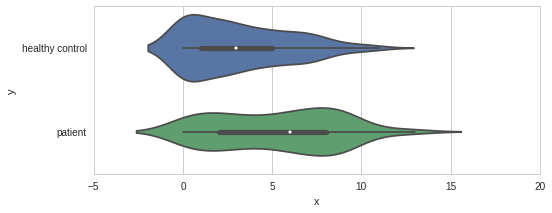

In [6]:
boxplot_subscale("legal_issues")

# Scale 2: WASI (intelligence)
This scale has been scored upon assessment.

In [7]:
subsets['WASI - intelligence'] = ['vocabulary_t_score',
'matrix_reasoning_t_score']

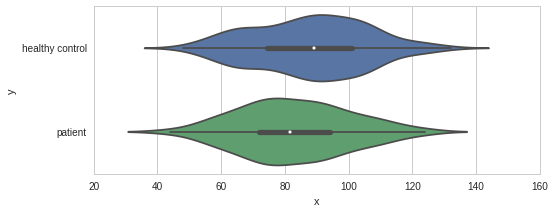

In [8]:
boxplot_subscale('WASI - intelligence')

# Scale 3: LDPS (lifetime dimensions of psychosis scale)

This scale needs quite a lot of preprocessing.  Basically, there is [Levinston, 2002](http://depressiongenetics.stanford.edu/researchfiles/LPDSPaper_published.pdf) that:
1. developed the preliminary version
2. did a factor analysis on it
3. based on the factor analysis changed the scale to the one used here.
We'll use their results from the factor analysis on the new scale. 

We won't do the weighted average resulting from the factor analysis in the paper, because the scales are not identical to the one assessed here.

Basically, there is often (but not always) a question of duration and of severity for each item _(eg. duration and severity of delusions)_.  First, these are summed together.  Next the variables that cluster together in subscales according to Levinston, are summed together _(eg. delusions+mania+...)_.

In [9]:
def add_labels(table,code,label,scale):
    table = table.append({'code':code,'label':label,'scale':scale},ignore_index=True)
    return table

# prepare LDPS

scales = {
    'delusions':['s4','s1','p2','p1','s2','nap'],
    'mania':['m1','m2','mp2'],
    'disorganization':['d1','d2'],
    'depression':['de1','de2'],
    'deterioration':['n1','n2','c'],
    'hallucinations':['s3'],
    'complicating':['a']   
}

ldps_scales = {}
codebook = pd.DataFrame({"code":[],'label':[],'scale':[]})

# delusions
ldps_scales['p1'] = RC.duration_p1.astype('float') + RC.severity_p1.astype('float') # delusions
ldps_scales['p2'] = RC.duration_p2.astype('float') + RC.severity_p2.astype('float') # paranoia
ldps_scales['p3'] = RC.duration_p3.astype('float') + RC.severity_p3.astype('float') # hallucinations
ldps_scales['s1'] = RC.duration_s1.astype('float') + RC.severity_s1.astype('float') # control delusions
ldps_scales['s2'] = RC.duration_s2.astype('float') + RC.severity_s2.astype('float') # bizarre delusions
ldps_scales['s4'] = RC.duration_s4.astype('float') + RC.severity_s4.astype('float') # perception of thought
ldps_scales['nap'] = RC.duration_nap.astype('float') + RC.severity_nap.astype('float') #nonaffective psychosis

codebook = add_labels(codebook,'p1','delusions','delusions')
codebook = add_labels(codebook,'p2','paranoia','delusions')
codebook = add_labels(codebook,'p3','hallucinations','delusions')
codebook = add_labels(codebook,'s1','control delusions','delusions')
codebook = add_labels(codebook,'s2','bizarre delusions','delusions')
codebook = add_labels(codebook,'s4','perception of thought','delusions')
codebook = add_labels(codebook,'nap','nonaffective psychosis','delusions')

# mania
ldps_scales['m1'] = RC.duration_m1.astype('float')+RC.severity_m1.astype('float') #mania
ldps_scales['m2'] = RC.m2.astype('float')
ldps_scales['mp2'] = RC.duration_mp2.astype('float') + RC.severity_mp2.astype('float') #mania+hallucinations or delusions

codebook = add_labels(codebook,'m1','mania','mania')
codebook = add_labels(codebook,'m2','manic features','mania')
codebook = add_labels(codebook,'mp2','mania+hallucinations','mania')

# disorganisation
ldps_scales['d1'] = RC.duration_d1.astype('float') + RC.severity_d1.astype('float') # formal thought disorder
ldps_scales['d2'] = RC.duration_d2.astype('float') + RC.severity_d2.astype('float') # bizarre behavior

codebook = add_labels(codebook,'d1','formal thought disorder','disorganisation')
codebook = add_labels(codebook,'d2','bizarre behavior','disorganisation')

#depression
ldps_scales['de1'] = RC.duration_de1.astype('float') + RC.severity_de1.astype('float') #depression
ldps_scales['de2'] = RC.de_2.astype('float')  #maximum of 9 depressive features concurrent for 2+weeks
ldps_scales['mp1'] = RC.duration_mp1.astype('float') + RC.severity_mp1.astype('float') # concurrent depressed 
                                                        # mood and delusion or hallucinations

codebook = add_labels(codebook,'de1','depression','depression')
codebook = add_labels(codebook,'de2','depressive features','depression')
codebook = add_labels(codebook,'mp1','concurrent depressed+delusion','depression')

# deterioration
ldps_scales['n1'] = RC.duration_n1.astype('float') + RC.severity_b1.astype('float') #blunted affect (note typo in code !)
ldps_scales['n2'] = RC.duration_n2.astype('float') + RC.severity_n2.astype('float') # poverty of speech
ldps_scales['c'] = RC.severity_c.astype('float') #deterioration

codebook = add_labels(codebook,'n1','blunted affect','deterioration')
codebook = add_labels(codebook,'n2','poverty of speech','deterioration')
codebook = add_labels(codebook,'c','deterioration','deterioration')

# hallucinations
ldps_scales['s3'] = RC.duration_s3.astype('float') + RC.severity_s3.astype('float') # ccc hallucinations 
                                                    # (conversing/commenting/continuous)
codebook = add_labels(codebook,'s3','ccc hallucinations','hallucinations')


# complicating
ldps_scales['a'] = RC.severity_a.astype('float')
codebook = add_labels(codebook,'a','complicating features','complicating features')

ldps_scales = pd.DataFrame(ldps_scales)

In [10]:
print(codebook)

   code                          label                  scale
0    p1                      delusions              delusions
1    p2                       paranoia              delusions
2    p3                 hallucinations              delusions
3    s1              control delusions              delusions
4    s2              bizarre delusions              delusions
5    s4          perception of thought              delusions
6   nap         nonaffective psychosis              delusions
7    m1                          mania                  mania
8    m2                 manic features                  mania
9   mp2           mania+hallucinations                  mania
10   d1        formal thought disorder        disorganisation
11   d2               bizarre behavior        disorganisation
12  de1                     depression             depression
13  de2            depressive features             depression
14  mp1  concurrent depressed+delusion             depression
15   n1 

Let's look at the correlations within and between the scales to verify if we indeed have a similar solution as the factor solution presented in Levinston 2002.

In [11]:
order = [np.where(x==ldps_scales.columns)[0][0] for x in codebook.code]
cor = np.array(ldps_scales.corr())
cor = cor[:,order]
cor = cor[order,:]
np.fill_diagonal(cor,1)

In [12]:
def correlation_plot(cor,labels,colrange,gridcolor='grey',title=None,figsize=(8,6)):
    mpl.rcParams['grid.color'] = gridcolor
    unique_labels = np.unique(labels)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] for idx,x in enumerate(labels)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-0.5 for x in range(len(unique_labels))]
    major_ticks.append(len(labels)-0.55)
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x)) for x in range(len(unique_labels))]
    fig = plt.figure(figsize=figsize, dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(cor,cmap = "PuOr_r",vmin=colrange[0],vmax=colrange[1],aspect='auto',interpolation='nearest')
    if title:
        ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()

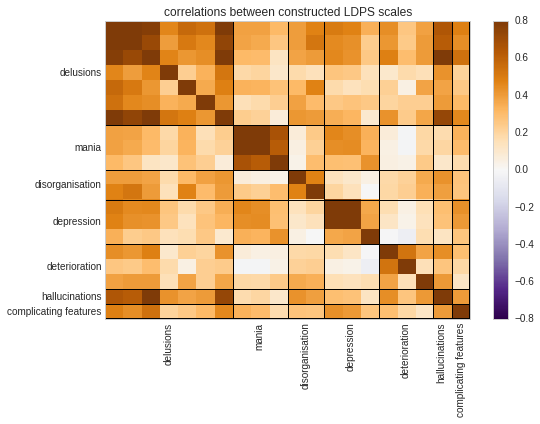

In [13]:
correlation_plot(cor,codebook.scale,[-0.8,0.8],gridcolor='black',title='correlations between constructed LDPS scales')

Insert the composite scores to RC and save the keys that we'll need to use.

In [14]:
for k,v in scales.iteritems():
    RC[k]=np.sum(pd.DataFrame(ldps_scales[v]).astype('float'),axis=1)

In [15]:
subsets['LDPS - lifetime dimensions of psychosis'] = scales.keys()

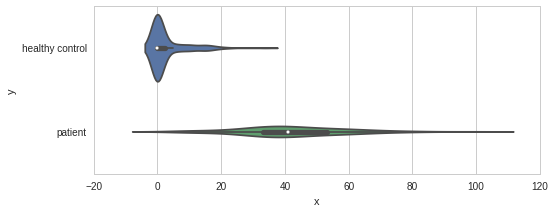

In [16]:
boxplot_subscale('LDPS - lifetime dimensions of psychosis')

# Scale 4: BPRS-E - brief psychiatric rating scale - extended

The BPRS-E is slightly more complex.  There is no composite score or factor analysis available, so we decided to just sum together all variables.  Upon inspection, it seems that there is some factor structure (see below), but many of these are covered in LDPS scale. 

In [17]:
bprse=[
    'somatic_concerns',
    'anxiety',
    'depression',
    'guilt',
    'hostility',
    'suspiciousness',
    'unusual_thought_content',
    'grandiosity',
    'hallucinations',
    'disorientation',
    'conceptual_disorganization',
    'excitement',
    'motor_retardation',
    'blunted_affect',
    'tension',
    'mannerisms_and_posturing',
    'uncooperativeness',
    'emotional_withdrawal',
    'suicidality',
    'self_neglect',
    'bizarre_behaviors',
    'elevated_mood',
    'motor_hyperactivity',
    'distractability'
]

In [18]:
subtab = RC[bprse].astype('float')
cor = np.array(subtab.corr())

This correlation matrix looks like there's a multidimensional scale, but see separate factor analysis results that show the instability of factor solutions.  Therefore we take the mean.

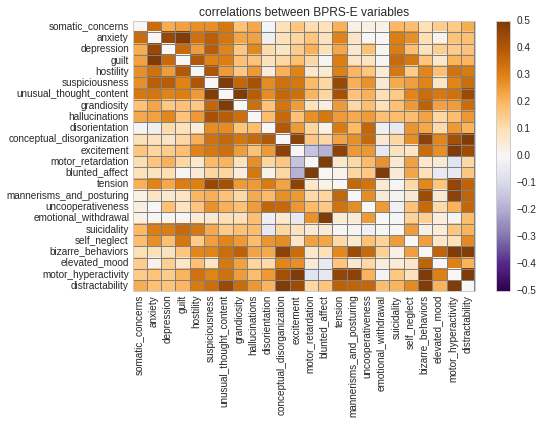

In [19]:
np.fill_diagonal(cor,0)
correlation_plot(cor = cor,
                 labels = bprse,
                 colrange = [-0.5,0.5],
                 gridcolor='grey',
                 title='correlations between BPRS-E variables')

In [20]:
RC['bprse_total_score']=np.sum(pd.DataFrame(subtab),axis=1)
subsets['bprse - psychiatric rating']=['bprse_total_score']

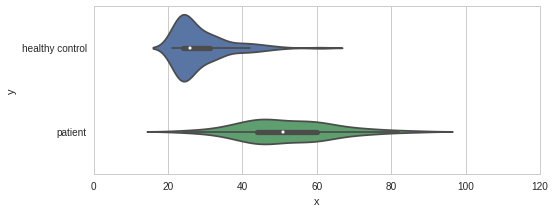

In [21]:
boxplot_subscale('bprse - psychiatric rating')

# Scale 5: HAMD - hamilton depression scale

In [22]:
subsets['HAMD - depression']=[
    'hamd_total_score'
]

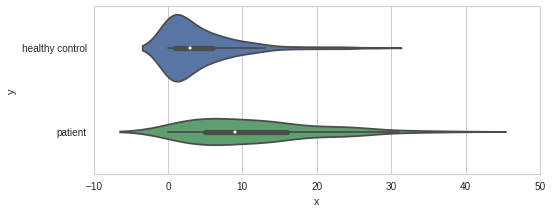

In [23]:
boxplot_subscale('HAMD - depression')

# Scale 6: YMRS

In [24]:
subsets['YMRS - young mania']=[
    'ymrs_total_score'
]

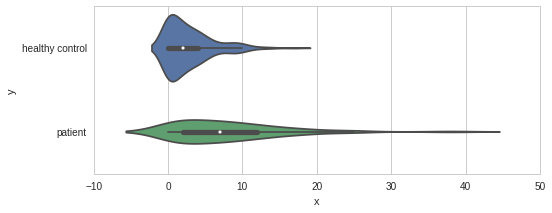

In [25]:
boxplot_subscale('YMRS - young mania')

# Scale 7: Subset Family History Assessment
This is a zero-inflated scale with **a lot** of items.  The list assesses for all variables (such as alcohol use) if there were issues in the family (father, mother, siblings,...).  We sum together all these variables to have a composite score measuring the number of family members that have this issue.

In [26]:
subsets['Family_History_Assessment']=[
    'alcohol_use_family',
    'drug_use_family',
    'depression_family',
    'mania_family',
    'schizophrenia_family',
    'antisocial_personality_fam',
    'anxiety_family',
    'mental_health_care_family',
    'psychiatric_hospitalizatio',
    'suicide_attempt_family',
    'suicide_complete_family',
    'tabacco_family'
]

In [27]:
for var in subsets['Family_History_Assessment']:
    allvars = ["%s___%i"%(var,x) for x in range(1,24)]
    RC[var] = np.sum(pd.DataFrame(RC[allvars]),axis=1)

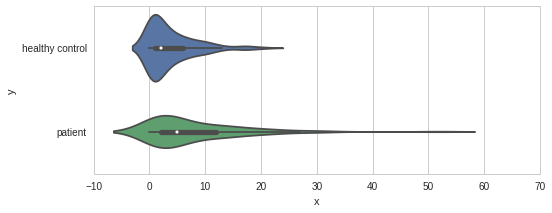

In [28]:
boxplot_subscale('Family_History_Assessment')

# Scale 8: CTQ - childhood trauma questionnaire

**Note:** I believe this scale was only assessed with the psychotic population: I'm checking with Dominique Denbow.

There are results available for a composite score.  See [this discussion on research gate](https://www.researchgate.net/post/Does_anyone_have_childhood_Trauma_Questionnaire_scoring_manual):

**Quote:**
I have the CTQ manual and here are the scoring cut offs:
- Emotional Abuse: None=5-8; Low=9-12; Moderate=13-15; Severe=16+
- Physical Abuse: None=5-7; Low=8-9; Moderate=10-12; Severe=13+
- Sexual Abuse: None=5; Low=6-7; Moderate=8-12; Severe=13+
- Emotional Neglect: None=5-9; Low=10-14; Moderate=15-17; Severe=18+
- Physical Neglect: None=5-7; Low=8-9; Moderate=10-12; Severe=13+

We sum together the items from the subscales.  As before, below we show how the correlation structure of our data _kind of_ reflects the factor solution from the manual.
**Note**: I'm not going to categorise these values using those cutoffs.  I guess it's better to keep these continuous.  **BUT** I will have to check for missing values (origin at 0) vs these sums (origin at 5)

In [29]:
cutoff = {
    'emotional_abuse':[8.5,12.5,15.5], #doing it with halves: this way I'm not going to mess up lower bounds.
    'physical_abuse':[7.5,9.5,12.5],
    'sexual_abuse':[5.5,7.5,12.5],
    'emotional_neglect':[9.5,14.5,17.5],
    'physical_neglect':[7.5,9.5,12.5]
}

In [30]:
ctq_scales = {
    "emotional_abuse":[
        'peopel_in_my_family_called',
        'i_thought_my_parents_wishe',
        'people_in_my_family_said_h',
        'i_felt_that_someone_in_my',
        'i_believe_i_was_emotionall'
    ],
    "physical_abuse":[
        'i_got_hit_so_hard_by_someo',
        'people_in_my_family_hit_me',
        'i_was_punished_with_a_belt',
        'i_believe_that_i_was_physi',
        'i_got_hit_or_beaten_so_bad'
    ],
    'sexual_abuse':[
        'someone_tried_to_touch_me',
        'someone_threatened_to_hurt',
        'someone_tried_to_make_me_d',
        'someone_molested_me',
        'i_believe_i_was_sexually_a',        
    ],
    'emotional_neglect':[
        'there_was_someone_in_my_fa', #negative !!
        'i_felt_loved', #negative
        'people_in_my_family_looked', #negative !!
        'people_in_my_family_felt_c', #negative !!
        'my_family_was_a_source_of', #negative        
    ],
    'physical_neglect':[
        'i_didn_t_have_enough_to_ea',
        'i_knew_there_was_someone_t', #negative !!
        'my_parents_were_too_drunk',
        'i_had_to_wear_dirty_clothe',
        'there_was_someone_to_take', #negative        
    ],
    'minimization/denial':[
        'there_was_nothing_i_wanted', #negative !!
        'i_had_the_perfect_childhoo', #negative !!
        'i_had_the_best_family_in_t', #negative        
    ]
}

negatives = [
        'there_was_someone_in_my_fa',
        'i_felt_loved',
        'people_in_my_family_looked',
        'people_in_my_family_felt_c',
        'my_family_was_a_source_of',        
        'i_knew_there_was_someone_t',
         'there_was_someone_to_take',        
        'there_was_nothing_i_wanted',
        'i_had_the_perfect_childhoo',
        'i_had_the_best_family_in_t',       
  
]

subsets['CTQ - child trauma']=[x for x in ctq_scales.keys()]

In [31]:
# this also checks whether all variables are present
all_vars = []; all_labels=[]
for k,v in ctq_scales.iteritems():
    all_vars += v
    all_labels += [k]*len(v)
all_CTQ = RC[all_vars].astype('float')

#### Redo negative items.

There are negative items.  These are transformed to positive.  Always check if we're doing the right thing here !

In [32]:
print(all_CTQ.i_felt_loved[135:].tolist())

[3.0, 5.0, 2.0, 5.0, 5.0, nan, 5.0, 4.0, 5.0, 4.0, 5.0, 1.0, 4.0, 4.0, 5.0, 4.0, 2.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 4.0, 5.0, 1.0, 4.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 4.0, nan, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 2.0, 5.0, 2.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 2.0, 4.0, 5.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 5.0, 2.0, 5.0, 5.0, 4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 2.0, 1.0, 5.0, 5.0, nan, 5.0, 5.0, 5.0, 4.0, 1.0, 3.0, 5.0, 5.0, 5.0, 3.0, 2.0, 5.0, 3.0, 3.0, 5.0, 4.0, 3.0, 5.0, 1.0, 2.0, 5.0, 5.0, 3.0, 1.0, 5.0, 5.0,

In [33]:
for negcol in negatives:
    all_CTQ.loc[:,negcol]=6-all_CTQ.loc[:,negcol]

In [34]:
print(all_CTQ.i_felt_loved[135:].tolist())

[3.0, 1.0, 4.0, 1.0, 1.0, nan, 1.0, 2.0, 1.0, 2.0, 1.0, 5.0, 2.0, 2.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0, 1.0, 5.0, 2.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, nan, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 4.0, 1.0, 4.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 5.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 5.0, 5.0, 4.0, 2.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 5.0, 1.0, 4.0, 1.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 4.0, 5.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 2.0, 5.0, 3.0, 1.0, 1.0, 1.0, 3.0, 4.0, 1.0, 3.0, 3.0, 1.0, 2.0, 3.0, 1.0, 5.0, 4.0, 1.0, 1.0, 3.0, 5.0, 1.0, 1.0,

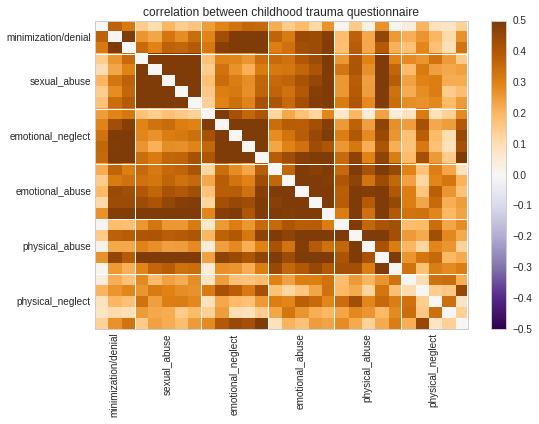

In [35]:
cor = np.array(all_CTQ.corr())
np.fill_diagonal(cor,0)
correlation_plot(cor = cor,
                 labels = all_labels,
                 colrange = [-0.5,0.5],
                 gridcolor='white',
                 title='correlation between childhood trauma questionnaire')

In [36]:
# construct new scales
for k,v in ctq_scales.iteritems():
    RC[k]=np.sum(all_CTQ[v],axis=1)

sumall = np.sum(all_CTQ)

subsets['CTQ - child trauma']=ctq_scales.keys()

This shows the distribution of scores.

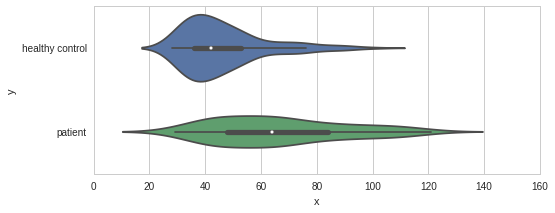

In [37]:
boxplot_subscale('CTQ - child trauma')

# Scale 9: THQ - trauma history questionnaire

This questionnaire measures the trauma history.  For each item there are 3 questions:
- did you experience it?
- how many times?
- approximate ages?

As suggested in the original paper of the scale, [Hooper, 2011](http://tandfonline.com/doi/pdf/10.1080/15325024.2011.572035?needAccess=true), we're summing over all questions assessing _how many times_ something happened.

**Quote:**
_The 24-item THQ can generate a total score
representing the numbers and types of events endorsed as well as subscale
scores, calculated by summing items associated with crime-related events
(4 items), general disaster and traumatic experiences (13 items), and physical
and sexual experiences (6 items). As previously mentioned, one item allows
for reports of traumatic experiences not covered in the other statements.
While this item is usually not scored unless the response provided has information
and relevance that may be appropriately scored under one of the
other 23 items, information from this question can be used at the discretion
of the investigator.
The most common scoring convention is to count the number of types of
events endorsed and=or subscale scores breaking down the counts by event
type. _

In [38]:
# note: as suggested, we're ignoring 'num_of_times_for_pse_q24'
scales = {
    "crime_related_trauma":[
        'number_of_times_for_cre_q%i'%x for x in range(1,5)
    ],
    "general_disaster":[
        'number_of_times_for_gd_q%i'%x for x in range(5,18)
    ],
     'physical_sexual':['number_of_times_for_pse_q1']+[
        'num_of_times_for_pse_q%i'%x for x in range(19,24) #typo :-\
    ]
}

#subsets['THQ - trauma history']=[x for x in scales.keys()]

In [39]:
# this also checks whether all variables are present
all_vars = []; all_labels=[]
for k,v in scales.iteritems():
    all_vars += v
    all_labels += [k]*len(v)
all_THQ = RC[all_vars]

In [40]:
# construct new scales
for k,v in scales.iteritems():
    RC[k]=np.sum(pd.DataFrame(all_THQ[v]),axis=1)

### PROBLEM: NON NUMERIC VALUES

In [41]:
#boxplot_subscale('THQ - trauma history')

KeyError: 'THQ - trauma history'

# Scale 10: SCID screener

**[DANGER DANGER]** This scale is ranging over (1: yes, 2:no, 3: maybe) **[\DANGER DANGER]** 

==> first things first: rescore.

We're going to sum over them

In [42]:
scid_screen=["have_you_ever_had_a_panic",
                          "were_you_ever_afraid_of_go",
                            "is_there_anything_that_you",
                            "are_there_any_other_things",
                            "have_you_been_bothered_by",
                            'ocd',
                            "over_the_last_six_months_h",
                            "has_there_been_any_time_in",
                            "have_you_ever_used_street",
                            "have_you_ever_gotten_hooke",
                            "have_you_ever_had_a_time_w",
                            "have_you_often_had_times_w",
                            'depression1',
                            'depression2',
                            'scid_suicide',
                            'mania1',
                            'mania2',
                            "have_you_ever_heard_things",
                            "has_it_ever_seemed_like_yo",
                            "have_you_ever_experienced",
                            "over_the_years_have_you_of",
                            "do_you_worry_much_about_yo",
                            "have_you_been_very_bothere",
                            "do_you_have_any_concerns_r"]

In [43]:
scidtab = RC[scid_screen].astype('float')
print(scidtab.depression1[140:].tolist())

[1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 3.0, 2.0, 1.0, 2.0, 2.0, 3.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, nan, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 3.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, nan, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, 1.0,

In [44]:
di = {
    1:3, # yes = 3
    3:2, # maybe - 2
    2:1} #no = 1
for col in scidtab.columns:
    scidtab[col].replace(di,inplace=True)

print(scidtab.depression1[140:].tolist())

[3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 1.0, 2.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 2.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, nan, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 2.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, nan, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 2.0, 3.0, 1.0, 3.0,

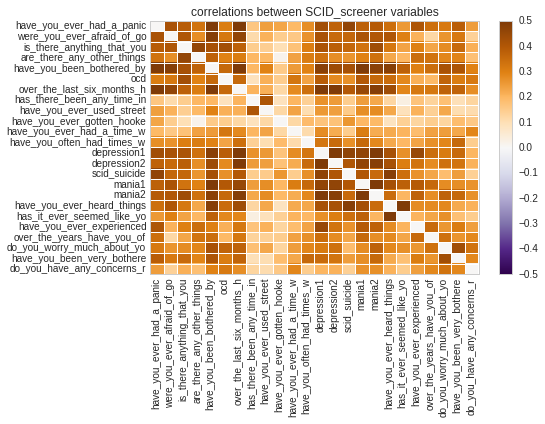

In [46]:
cor = np.array(scidtab.corr())
np.fill_diagonal(cor,0)
correlation_plot(cor = cor,
                 labels = scid_screen,
                 colrange = [-0.5,0.5],
                 gridcolor='white',
                 title='correlations between SCID_screener variables')

In [47]:
RC['scid_screener']=np.sum(pd.DataFrame(scidtab),axis=1)
subsets['scid_screener - structured interview']=['scid_screener']

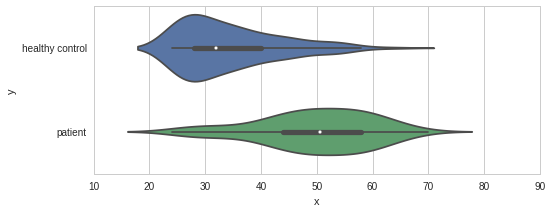

In [48]:
boxplot_subscale('scid_screener - structured interview')

# Scale 11: SCID face and axis diagnosis

In [49]:
subsets['scid_face_axis - structured interview'] = [
    'sex',
    'age',
    'has_there_ever_been_a_prio', #unable to work or go to school
    'is_there_a_mood_diagnosis',
    'is_there_a_history_of_subs',
    'current_cannabis_use'
    ]

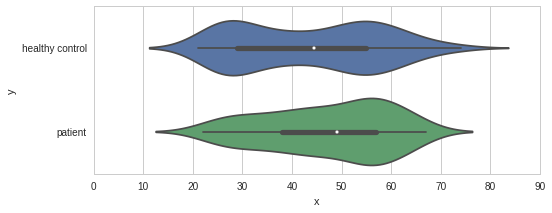

In [50]:
boxplot_subscale('scid_face_axis - structured interview')

# Combine all

In [51]:
all_vars = []; all_labels=[]
for k,v in subsets.iteritems():
    all_vars += v
    all_labels += [k]*len(v)

RC_clean = RC[all_vars].astype('float')

print("We now have %i variables"%len(all_vars))

We now have 52 variables


In [52]:
# add subject status and UID
RC_clean['patient']=RC['is_this_subject_a_patient']
RC_clean['UID']=RC['UID']

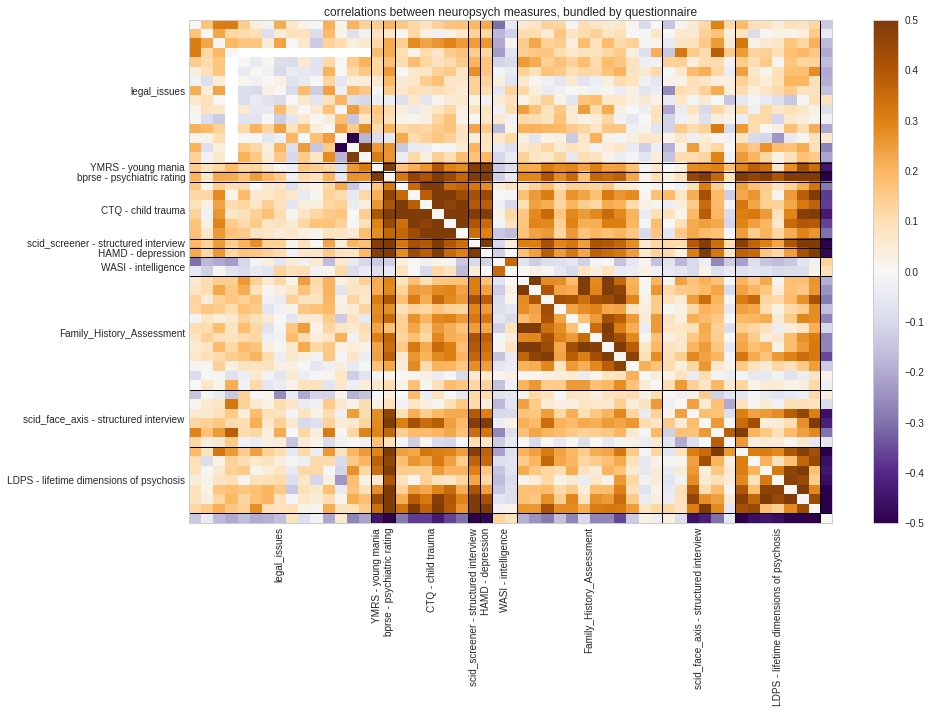

In [53]:
cor = np.array(RC_clean.corr())
np.fill_diagonal(cor,0)
correlation_plot(cor = cor,
                 labels = all_labels,
                 colrange = [-0.5,0.5],
                 gridcolor='black',
                 title='correlations between neuropsych measures, bundled by questionnaire',
                 figsize=(14,10)
                )

# Are there highly discriminating factors

In [58]:
listvars = np.array([x for sublist in subsets.values() for x in sublist if not x in ['is_this_subject_a_patient','UID']])

RC_norm = pd.DataFrame({x:[] for x in RC_clean.columns})

catvars = []; convars = []

for idx,col in enumerate(listvars):

    cnt = Counter(RC_clean[col]).keys()
    nonna = np.array(cnt)[np.isfinite(cnt)]
    if len(nonna)>2:
        convars.append(col)
        RC_norm[col]=(RC_clean[col]-np.mean(RC_clean[col]))/(1*(np.std(RC_clean[col])))
    else:
        catvars.append(col)

RC_norm['patient']=['patient' if x==888 else 'healthy control' for x in RC.is_this_subject_a_patient]

cols = {0:np.array(convars)[np.arange(0,int(len(convars)/2))],
        1:np.array(convars)[np.arange(int(len(convars)/2),len(convars))]}

## Continuous variables

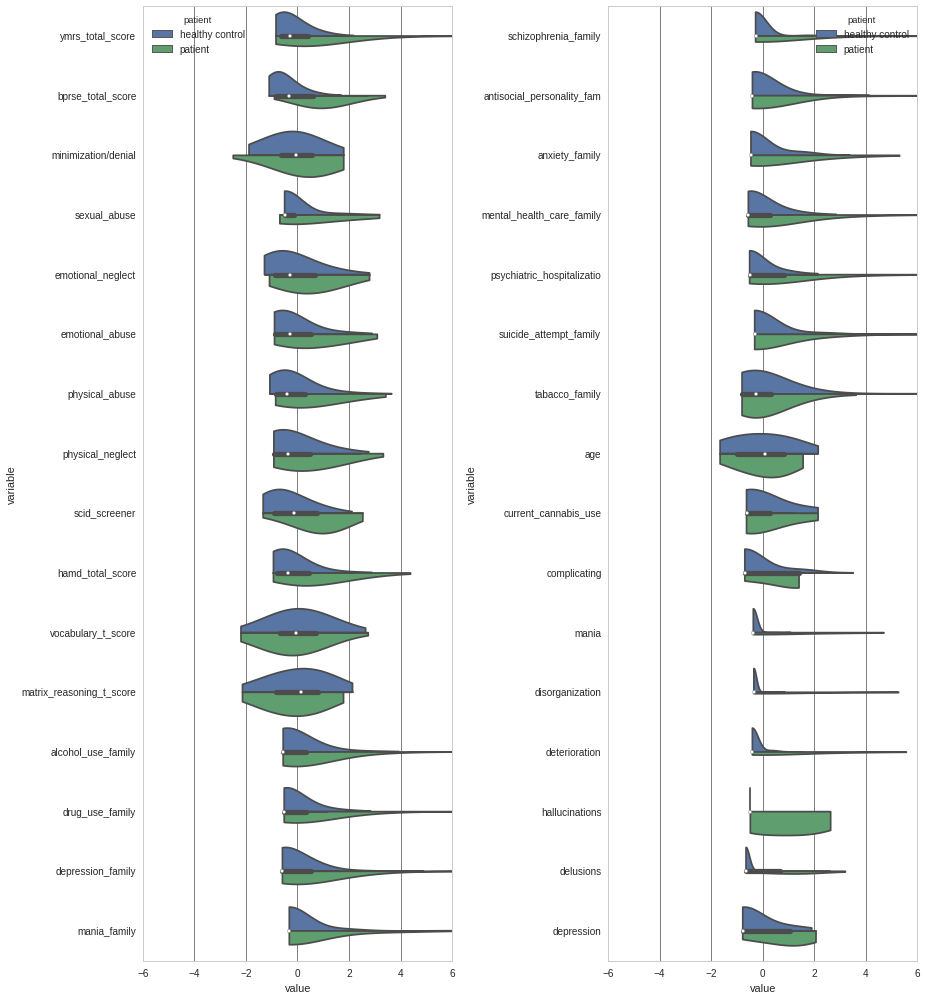

In [59]:
mpl.rcParams['grid.color'] = 'grey'
f, axes = plt.subplots(1, 2, figsize=(13, 14), sharex=True)
for col in range(2):
    RC_sel = RC_norm[np.append(cols[col],'patient')]
    newdat = pd.melt(RC_sel,id_vars = ['patient'],value_vars = cols[col].tolist())
    sns.violinplot(x='value',y='variable',data=newdat,orient='h',hue='patient',bw=1,
                   title='distribution of continuous variables by patient',
                   split=True,ax=axes[col],cut=0)
    plt.xlim([-6,6])
    plt.tight_layout()

## Categorical variables

/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jdurnez/.conda/envs/my_root/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


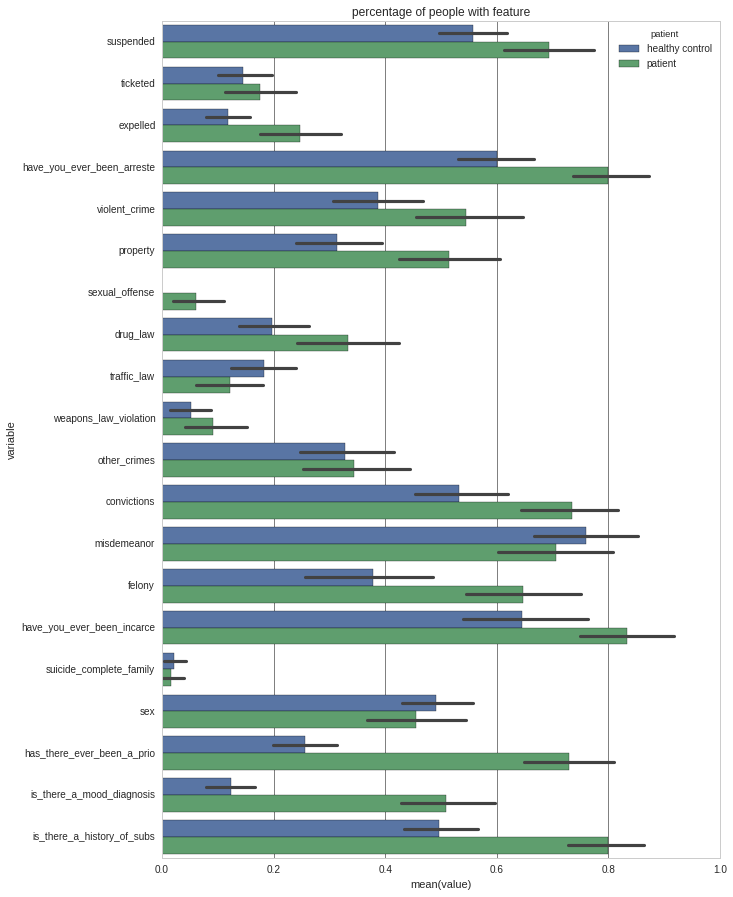

In [60]:
mpl.rcParams['grid.color'] = 'grey'
plt.figure(figsize=[10,15])
catdf = RC_clean[catvars]
catdf['patient']=['patient' if x==888 else 'healthy control' for x in RC.is_this_subject_a_patient]
catdf['sex']=catdf['sex']-1
catdf = pd.melt(catdf,id_vars = ['patient'],value_vars = catvars)

sns.barplot(x='value',y='variable',hue='patient',data=catdf,orient='h')
plt.title("percentage of people with feature")

# Write away

In [61]:
RC_clean.to_csv(os.path.join(os.environ.get("TABLEDIR"),"neuropsych_clean.csv"))

In [62]:
subsetfile = os.path.join(os.environ.get("TABLEDIR"),"neuropsych_clean_dict.json")
with open(subsetfile, 'w') as file:
     file.write(json.dumps(subsets))